# How partisan is your state?

In this notebook, we explore the partisan preferences of all fifty states using the turnout-weighted average of recent Senate election results.

## Data collection

Our data comes from election results spreadsheets made by the Federal Election Comission. For each federal election from 2002 to 2016, we have extracted the General Election columns from the "Senate By Party" sheet and included them as `.csv` files in the `raw_csv` folder of this repository. The entire summary documents may be downloaded from [this page](https://transition.fec.gov/pubrec/electionresults.shtml) on the FEC websie, which we accessed October 17th, 2018.

In addition to copying the columns, we removed all asterisks (for footnotes) from the state abbreviations, and normalized the column headers as follows:

* `State`: 2-letter state abbreviation
* `Democratic`: Democratic vote count
* `Republican`: Republican vote count
* `Other`: total non-Democratic, non-Republican vote count


## Data tidying

Now that we have the raw election results, we join them into a single [tidy](http://r4ds.had.co.nz/tidy-data.html) dataset describing the Republican and Democratic vote totals in all Senate election races in all states from 2002 to 2016, excluding races where an independent candidate won.

We want each row of our table to be a record of a single Senate race. To do this, we join the contents of all of our raw CSV files into a single dataframe.

In [40]:
%matplotlib inline
import math
import pathlib

import geopandas
import matplotlib
orig = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = [orig[0] * 1.5, orig[1] * 1.5]
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy
import pandas

In [41]:
df = pandas.DataFrame(data=[], columns=["State", "Democratic", "Republican", "Other", "Year"])

csv_folder = pathlib.Path("./raw_csv/")

for filepath in csv_folder.iterdir():
    if filepath.suffix == ".csv":
        year = filepath.stem
        
        table = pandas.read_csv(filepath)
        table["Year"] = year
        
        df = df.append(table)

To check our work, we verify that the `Year` column holds 8 unique values (one for each election cycle from 2002 to 2016):

In [42]:
df['Year'].describe()

count      419
unique       8
top       2014
freq        56
Name: Year, dtype: object

### Cleaning up NA values

Our table contains some empty rows, because not every state has a Senate election each year. We also have empty rows for territories without representation, like Puerto Rico and the District of Columbia.

We remove these empty records.

In [43]:
# Drop all records for elections that didn't happen
df.dropna(how="all", subset=("Democratic", "Republican", "Other"), inplace=True)

For some elections where a party received no votes (e.g. unopposed races) the party's cell was left empty. This is parsed as `NaN` by pandas. We correct these NA values to zeros.

In [44]:
df.fillna(0, inplace=True)

### Independent candidates

Some elections in our dataset were won by candidates who were not Republicans or Democrats. Let's see how many are like that.

In [45]:
parties = ["Democratic", "Republican", "Other"]

other_won = df[df["Other"] == df[parties].max(axis=1)]

other_won

,State,Democratic,Republican,Other,Year
7,CT,450844.0,109198.0,574738.0,2006
47,VT,0.0,84924.0,177495.0,2006
26,MS,480915.0,766111.0,1243473.0,2008
1,AK,60045.0,90839.0,106654.0,2010
21,ME,92900.0,215399.0,392300.0,2012
49,VT,0.0,72898.0,219864.0,2012


Here's what happended in each of these races.

* CT 2006: won by Joe Lieberman, Independent.
* VT 2006: won by Bernie Sanders, Independent.
* VT 2012: won by Bernie Sanders, Independent.
* AK 2010: won by Lisa Murkowski, write-in.
* ME 2012: won by Angus King, Independent.
* MS 2008: see below, under Special elections.

The winning candidates in CT, AK, and ME were all bona fide independents; both Republican and Democratic candidates appeared on the ballot and received substantial numbers of votes. Since our interest is in the partisan preferences of voters, we omit these elections from the dataset.

No Democratic candidate appeared on the ballot in Vermont in 2006 or 2012. As such, it would be reasonable to move Sen. Sanders's votes to the `Democratic` column, given that Sanders caucuses with the Democrats and ran for president as a Democrat in 2016. The original dataset is recorded by candidate, so this is possible without adding all of the other third-party votes (which are aggregated along with Sanders's votes in the `Other` column). Instead, we omit these elections from the dataset, since they would not significantly change the results that we get using the other Vermont elections, which Democratic Sen. Patrick Leahy won by large margins.

In [46]:
independents_won = (df["Other"] == df[parties].max(axis=1)) & (df["State"] != "MS")

df = df[independents_won == False]

We have no use for the `Other` column now, so we drop it from the dataset.

In [47]:
df.drop(["Other"], axis=1, inplace=True)

In [48]:
df.columns

Index(['State', 'Democratic', 'Republican', 'Year'], dtype='object')

### Special elections

The FEC documents advise us: "For states that had votes for both full and unexpired terms, the votes for both terms are included in the totals." This affects the following Senate totals:
* [Mississippi, 2008](https://en.wikipedia.org/wiki/United_States_Senate_special_election_in_Mississippi,_2008)
* [Illinois, 2010](https://en.wikipedia.org/wiki/United_States_Senate_elections_in_Illinois,_2010)
* [New York, 2010](https://en.wikipedia.org/wiki/United_States_Senate_special_election_in_New_York,_2010)
* [Hawaii, 2014](https://en.wikipedia.org/wiki/United_States_Senate_special_election_in_Hawaii,_2014)
* [Oklahoma, 2014](https://en.wikipedia.org/wiki/United_States_Senate_special_election_in_Oklahoma,_2014)
* [South Carolina, 2014](https://en.wikipedia.org/wiki/United_States_Senate_special_election_in_South_Carolina,_2014)

There was no general election Senate race in Hawaii in 2014, so that record in our dataset refers to a single election.

In the 2008 special election for the Mississippi senate, the Republican and Democratic candidates both appeared on the ballot without party affiliation. In the summary spreadsheet that I used, both these vote totals were added to the `Other` column for the 2008 election cycle, on top of the totals from the regularly-scheduled November 2008 Senate election.

We use the Wikipedia articles (accessed 10/19/2018) for each of these elections to extract the special election vote counts into their own columns.

In [49]:
# We are interested in Elections, not Years. This will let us identify special elections separately
df.rename(columns={"Election": "Year"}, inplace=True)
df.columns

Index(['State', 'Democratic', 'Republican', 'Year'], dtype='object')

In [50]:
special_elections = pandas.DataFrame({
    "State": ["MS", "IL", "NY", "OK", "SC"],
    "Year": ["2008", "2010", "2010", "2014", "2014"],
    "Republican": [683409, 1778698, 1582603, 557002, 757215],
    "Democratic": [560064, 1719478, 2837589, 237923, 459583],
    "Special": [True, True, True, True, True]
})

In [51]:
df["Special"] = False
df.columns

Index(['State', 'Democratic', 'Republican', 'Year', 'Special'], dtype='object')

In [52]:
df = df.append(special_elections, sort=False, ignore_index=True)

In [53]:
to_subtract = df[df["Special"] == True].groupby(["State", "Year"])

def correct_special_elections(df=df, to_subtract=to_subtract):
    for i in df.index:
        group = (df.loc[i]["State"], df.loc[i]["Year"])
        if group in to_subtract:
            to_subtract_index = to_subtract[group][0]
            df.loc[i]["Democratic"] -= df.loc[to_subtract_index]["Democratic"]
            df.loc[i]["Republican"] -= df.loc[to_subtract_index]["Republican"]

In [54]:
# Subtract special elections totals from original values
correct_special_elections()

### Unopposed candidates

Even in the Senate there are elections with a single candidate running unopposed. We _will_ include these in our `.csv`, but draw attention to them here. We will omit these records from our turnout-equalized averages below.

In [55]:
winner_unopposed = df[["Republican", "Democratic"]].min(axis=1) == 0

df[winner_unopposed]

,State,Democratic,Republican,Year,Special
9,KS,0.0,641075.0,2002,False
13,MA,1605976.0,0.0,2002,False
16,MS,0.0,533269.0,2002,False
31,VA,0.0,1229894.0,2002,False
44,ID,0.0,499796.0,2004,False
73,IN,0.0,1171553.0,2006,False
101,AR,804678.0,0.0,2008,False
161,SD,0.0,227947.0,2010,False
198,AL,0.0,795606.0,2014,False
208,KS,0.0,460350.0,2014,False


### Saving the dataset

Now that we have our desired dataset, we save it as `senate_elections_2002-2016.csv`.

In [56]:
df.to_csv("./senate_elections_2002-2016.csv", index=False) # omit the index, since it is meaningless

## Turnout-equalized averages

If we average the vote totals for a given party in a given state across multiple elections, then high-turnout election years (especially presidential election years) will have higher weight in the average. To avoid this, we weight the individual vote totals to equalize turnout.

If Party A received vote totals $A_1, A_2, \ldots, A_n$ in a set of elections with total turnout $T_1, T_2, \ldots, T_n$, then the _turnout-equalized average_ vote total for Party A is the average of $\frac{A_1}{T_1}, \frac{A_2}{T_2}, \ldots, \frac{A_n}{T_n}$, multiplied by the average of $T_1, T_2, \ldots, T_n$

In other words, it is the average percentage of the vote that A received multiplied by the average total turnout.

In [57]:
def turnout_equalized_average(votes, totals):
    return numpy.mean(votes / totals) * numpy.mean(totals)

We now compute the turnout-equalized average for each party in each state, using only the Senate elections where
* The Democratic or Republican party candidate won the race (i.e., no independent candidates or write-ins)
* Candidates from both parties appeared on the ballot (i.e., no unopposed races)

In [58]:
all_elections = pandas.read_csv("./senate_elections_2002-2016.csv")
all_elections["Year"] = all_elections["Year"].astype(str)

df = all_elections[winner_unopposed == False]

We compute separate equalized averages for the 2000-2010 and 2010-2020 census cycles.

In [59]:
def equalize_column(df, column, totals):
    return df.groupby("State")[column].apply(lambda x: turnout_equalized_average(x, totals))

def equalize(df, columns=["Democratic", "Republican", "Other"]):
    totals = df[columns].sum(axis=1)
    equalized = pandas.DataFrame({
        column: equalize_column(df, column, totals)
        for column in columns
    })
    equalized["Number_of_Elections_Included"] = df.groupby("State")["Year"].count()
    return equalized

In [60]:
def percents(df):
    return df.apply(lambda x: x / numpy.sum(x), axis=1)

In [61]:
def equalize_and_attach_percents(dataframe, columns=["Democratic", "Republican"]):
    df = equalize(dataframe, columns)
    df = df.join(percents(df)[columns], rsuffix="_Percent")
    return df

In [62]:
df2000 = df[df["Year"].isin({"2002", "2004", "2006", "2008", "2010"})]
df2010 = df[df["Year"].isin({"2012", "2014", "2016"})]

In [63]:
df2000_eq = equalize_and_attach_percents(df2000)
df2000_eq.to_csv("./turnout_equalized_2002-2010.csv")

df2010_eq = equalize_and_attach_percents(df2010)
df2010_eq.to_csv("./turnout_equalized_2012-2016.csv")

df_eq = equalize_and_attach_percents(df)
df_eq.to_csv("./turnout_equalized_all.csv")

## Plots

In [64]:
blue = "#1976d2"
red =  "#d32f2f"

Text(0.5,1,'Votes Cast for Senate')

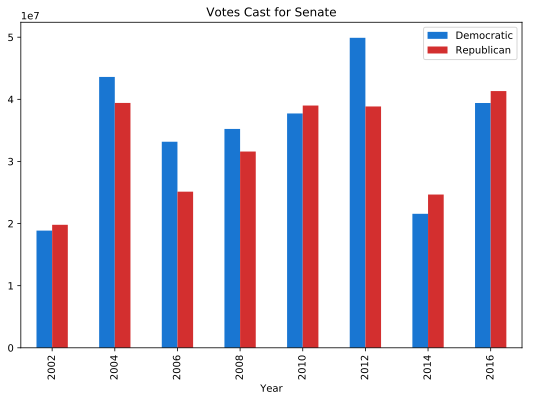

In [65]:
plot = df.groupby("Year")[["Democratic", "Republican"]].sum().plot.bar(color=[blue, red])
plot.set_title("Votes Cast for Senate")

In [66]:
def plot_histogram(df, parties=["Democratic", "Republican"]):
    winners = pandas.DataFrame({
        party: df[
            df[party] == df[parties].max(axis=1)
        ][party + "_Percent"]
        for party in parties
    })
    plot = winners.plot.hist(stacked=True, bins=15, color=[blue, red])
    return plot

Text(0.5,1,"Favored Party's Vote Share, by State, Both Census Cycles")

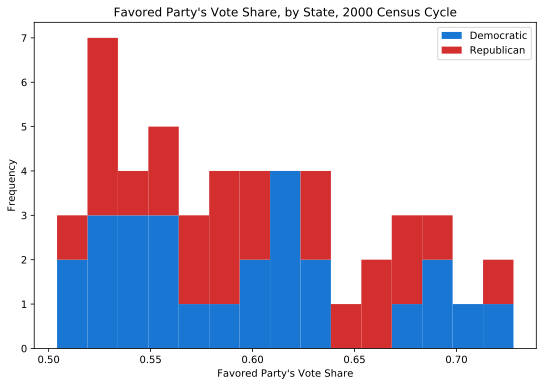

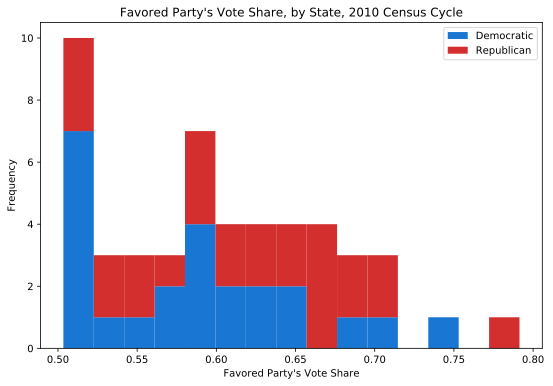

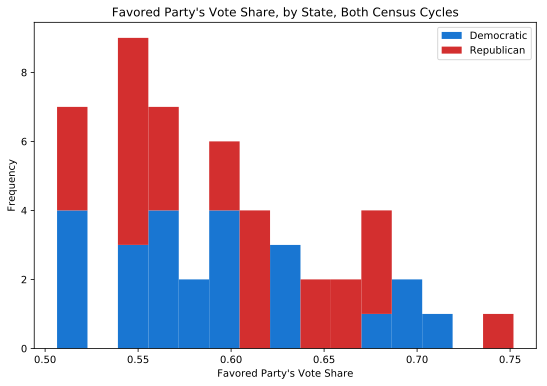

In [79]:
plot = plot_histogram(df2000_eq)
plot.set_xlabel("Favored Party's Vote Share")
plot.set_title("Favored Party's Vote Share, by State, 2000 Census Cycle")

plot = plot_histogram(df2010_eq)
plot.set_xlabel("Favored Party's Vote Share")
plot.set_title("Favored Party's Vote Share, by State, 2010 Census Cycle")

plot = plot_histogram(df_eq)
plot.set_xlabel("Favored Party's Vote Share")
plot.set_title("Favored Party's Vote Share, by State, Both Census Cycles")

Races won by independents or write-in candidates not included. The vote share is two-way vote share (i.e., third-party votes are not counted toward the total). Unopposed races not included.

## Overall favored party, by state

In [68]:
def winner_of_election(election_record):
    if election_record["Democratic"] > election_record["Republican"]:
        return "D"
    else:
        return "R"

In [69]:
def winner_or_na(filtered):
    if len(filtered) > 0:
        return winner_of_election(filtered.iloc[0])
    return None

def winner_for_year(group, year):
    return winner_or_na(group[group["Year"] == year])

grouped = df.groupby("State")

years = ["2002", "2004", "2006", "2008", "2010", "2012", "2014", "2016"]

outcomes = pandas.DataFrame({
    year: grouped.apply(lambda group: winner_for_year(group, year))
    for year in years
})

def favored_party(df):
    return (df["Democratic_Percent"] > df["Republican_Percent"]).map({True: "D", False: "R"})

outcomes["Favored_Party"] = favored_party(df_eq)
outcomes["Favored_Party_Vote_Share"] = df_eq[["Democratic_Percent", "Republican_Percent"]].max(axis=1)

In [70]:
def color_outcomes(value):
    if value == "R":
        return "background: #ffa7a7"
    elif value == "D":
        return "background: #8cbff1"
    else:
        return ""

outcomes.style.applymap(color_outcomes)

,2002,2004,2006,2008,2010,2012,2014,2016,Favored_Party,Favored_Party_Vote_Share
State,,,,,,,,,,
AK,R,R,None,D,None,None,R,R,R,0.638935
AL,R,R,None,R,R,None,None,R,R,0.639792
AR,D,D,None,None,R,None,R,R,R,0.54486
AZ,None,R,R,None,R,R,None,R,R,0.610584
CA,None,D,D,None,D,D,None,None,D,0.60294
CO,R,D,None,D,D,None,R,D,D,0.513592
CT,None,D,None,None,D,D,None,D,D,0.603628
DE,D,None,D,D,D,D,D,None,D,0.632691
FL,None,R,D,None,R,D,None,R,R,0.514719


Text(0.5,1,"Winner's Vote Share, by Election, Both Cycles")

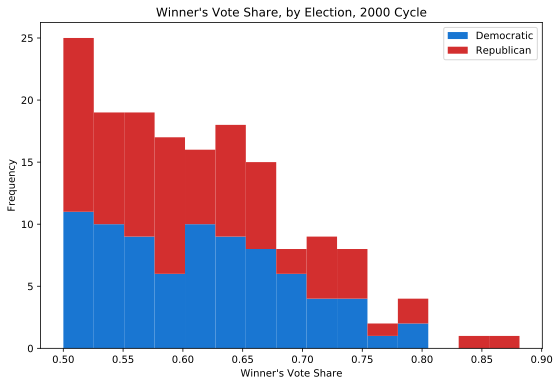

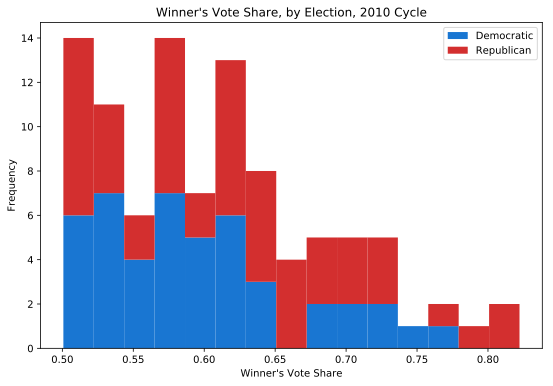

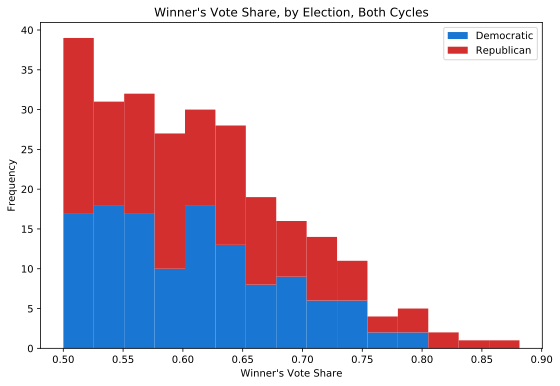

In [71]:
def plot_all_winners(df, parties=["Democratic", "Republican"]):
    totals = df[parties].sum(axis=1)

    def won_by(party, df):
        return df[party] == df[parties].max(axis=1)

    all_winners = pandas.DataFrame({
        party: df[won_by(party, df)][party] / totals
        for party in parties
    })
    return all_winners.plot.hist(stacked=True, bins=15, color=[blue, red])

plot = plot_all_winners(df[df["Year"].isin({"2002", "2004", "2006", "2008", "2010"})])
plot.set_xlabel("Winner's Vote Share")
plot.set_title("Winner's Vote Share, by Election, 2000 Cycle")

plot = plot_all_winners(df[df["Year"].isin({"2012", "2014", "2016"})])
plot.set_xlabel("Winner's Vote Share")
plot.set_title("Winner's Vote Share, by Election, 2010 Cycle")

plot = plot_all_winners(df)
plot.set_xlabel("Winner's Vote Share")
plot.set_title("Winner's Vote Share, by Election, Both Cycles")

Races won by independents or write-in candidates not included. The vote share is two-way vote share (i.e., third-party votes are not counted toward the total). Unopposed races not included.

## Maps

In [72]:
usa = geopandas.read_file("./cb_2017_us_state_20m/cb_2017_us_state_20m.shp")
albers = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83"

usa = usa.to_crs(albers)
lower_48 = usa[usa["STUSPS"].apply(lambda x: x not in {"AK", "HI"})]

In [73]:
def margins(df):
    return abs(df["Democratic_Percent"] - df["Republican_Percent"])

In [74]:
def winners_pct(df):
    return df[["Democratic_Percent", "Republican_Percent"]].max(axis=1)

In [75]:
colors = [(68, 13, 84), (71, 52, 128), (53, 95, 141), (34, 146, 139), (95, 202, 96), (253, 231, 37)]
float_colors = [(r/255, g/255, b/255) for r, g, b in colors]

def plot_winners_pct(df, cycle, usa=usa,
                     bins=[(.50,.53), (.53,.56), (.56,.60), (.60,.65), (.65, .70), (.70, 1.0)],
                     colors = float_colors,
                     full_cycle_df=equalize_and_attach_percents(df)):
    geo = usa.join(pandas.DataFrame({
        "winners_pct": winners_pct(df)
    }), on="STUSPS").dropna(how="any")

    fig, ax = plt.subplots(1, 1, dpi=100)
    
    base = usa.join(pandas.DataFrame({
        "winners_pct": winners_pct(full_cycle_df),
    }), on="STUSPS").dropna(how="any")
    
    base.plot(ax = ax, alpha=0)

    patches = []
    
    for (lower, upper), color in zip(bins, colors):
        patches.append(mpatches.Patch(
            color=color,
            label="{} - {}%".format(math.floor(lower*100), math.floor(upper*100))))
        subset = geo[(geo["winners_pct"] >= lower) & (geo["winners_pct"] < upper)]
        subset.plot(ax=ax, color=color)
    
    leg = plt.legend(handles=patches)
    leg.set_bbox_to_anchor((0.25, 0.25))
    ax.axis('off')
    ax.set_title("Favored Party's Average Vote Share, {}".format(cycle))

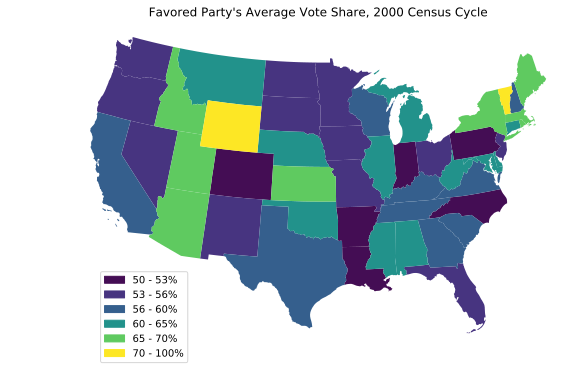

In [76]:
plot_winners_pct(df2000_eq, "2000 Census Cycle", usa=lower_48)

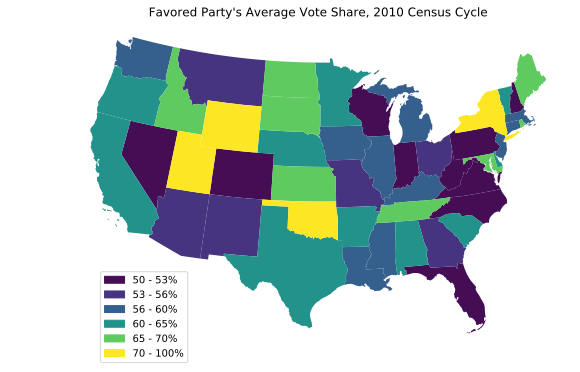

In [77]:
plot_winners_pct(df2010_eq, "2010 Census Cycle", usa=lower_48)

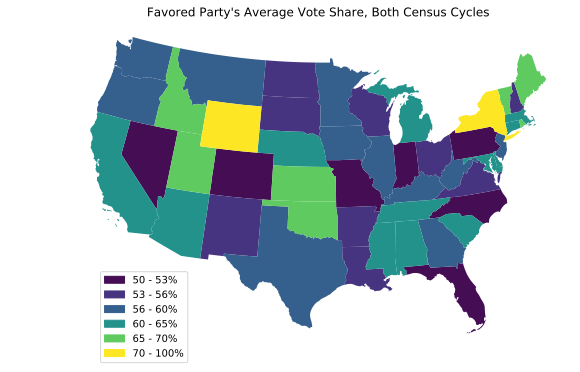

In [78]:
plot_winners_pct(equalize_and_attach_percents(df), "Both Census Cycles", usa=lower_48)